## Dataset and preprocessing

In [2]:
import numpy as np

In [2]:
def generate_linear_dataset(size=1000, num_features=10):
    X = np.random.rand(size, num_features)
    # Assuming a linear relationship with some noise
    true_weights = np.random.rand(num_features + 1)  # Including bias term
    true_weights[-1] = 0.0  # Set bias term to zero for simplicity
    y = np.dot(np.hstack([X, np.ones((size, 1))]), true_weights) + np.random.normal(0, 0.1, size)
    return X, y

In [3]:
def generate_non_linear_dataset(size=1000, num_features=10):
    X = np.random.rand(size, num_features)
    true_weights = np.random.rand(num_features + 1)
    true_weights[-1] = 0.0
    y_linear = np.dot(np.hstack([X, np.ones((size, 1))]), true_weights)
    y_nonlinear = np.sin(y_linear) + np.random.normal(0, 0.1, size)
    return X, y_nonlinear

## Implementation

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import pyro
from pyro.nn import PyroModule, PyroSample
from pyro.distributions import Normal, constraints
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

### Base BNN

In [5]:
class BNN(PyroModule):
    def __init__(self, num_features):
        super(BNN, self).__init__()
        # Define a standard PyTorch parameter for the weights
        self.fc1_weight = nn.Parameter(torch.randn(1, num_features))
        # Define a PyroSample for the bias with a prior distribution
        self.fc1_bias = PyroSample(Normal(0., 1.).expand([1]).to_event(1))

    def forward(self, x):
        # Use the standard PyTorch parameter and the PyroSample in your model
        f = torch.matmul(x, self.fc1_weight.T) + self.fc1_bias
        return f.squeeze()

### Gauss Newton Optimiser

In [6]:
def gauss_newton_optimizer(model, x, y, learning_rate=0.1, num_iterations=1000):
    for iteration in range(num_iterations):
        # Forward pass
        output = model(x)

        # Calculate loss
        loss = nn.MSELoss()(output.squeeze(), y)

        # Initialize approximate Hessian and gradient vector
        total_params = sum(p.numel() for p in model.parameters())
        approx_hessian = torch.zeros(total_params, total_params)
        loss_grads = torch.zeros(total_params)

        idx = 0
        for param in model.parameters():
            # Compute Jacobian for each parameter
            def model_output_with_params(p):
                original_param = param.data.clone()
                param.data = p.data
                output = model(x).squeeze()
                param.data = original_param
                return output

            jacobian = torch.autograd.functional.jacobian(model_output_with_params, param)
            jacobian_flat = jacobian.view(jacobian.size(0), -1)

            # Update approximate Hessian
            outer_product = jacobian_flat.T @ jacobian_flat
            numel = param.numel()
            approx_hessian[idx:idx+numel, idx:idx+numel] = outer_product

            # Update loss gradients
            loss_grad = torch.autograd.grad(loss, param, retain_graph=True)[0].view(-1)
            loss_grads[idx:idx+numel] = loss_grad

            idx += numel

        # Solve for the parameter update (using a pseudo-inverse for stability)
        update_direction = torch.linalg.pinv(approx_hessian) @ loss_grads

        # Update parameters
        with torch.no_grad():
            idx = 0
            for param in model.parameters():
                numel = param.numel()
                param_update = update_direction[idx:idx + numel].view(param.shape)
                param -= learning_rate * param_update
                idx += numel

                # Check for NaN values
                if torch.isnan(param).any():
                    print("NaN values encountered. Adjust the learning rate.")
                    return model

    return model

### SOTA - Adam

In [7]:
def adam_optimizer(model, x, y, learning_rate=0.01, num_epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    return model

## Results

### Linear and Non-Linear

Evaluation Function

In [8]:
def evaluate_model(model, x, y_true):
    with torch.no_grad():
        predictions = model(x).numpy()
    mse = mean_squared_error(y_true, predictions)
    r2 = r2_score(y_true, predictions)
    return mse, r2, predictions

In [9]:
# Initialize data storage for results
results = []

# Generate 100 different linear samples and evaluate
for i in range(100):
    # Generate a new linear dataset
    X, y = generate_linear_dataset()

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Initialize BNN models for each optimizer
    bnn_model_adam = BNN(num_features=X.shape[1])
    bnn_model_gn = BNN(num_features=X.shape[1])

    # Train and evaluate using Adam optimizer
    trained_adam = adam_optimizer(bnn_model_adam, X_tensor, y_tensor)
    mse_adam, r2_adam, _ = evaluate_model(trained_adam, X_tensor, y_tensor)

    # Train and evaluate using Gauss-Newton optimizer
    trained_gn = gauss_newton_optimizer(bnn_model_gn, X_tensor, y_tensor)
    mse_gn, r2_gn, _ = evaluate_model(trained_gn, X_tensor, y_tensor)

    # Store the results
    results.append({
        'Iteration': i+1,
        'X': X,
        'y': y,
        'Adam_MSE': mse_adam,
        'Adam_R2': r2_adam,
        'GaussNewton_MSE': mse_gn,
        'GaussNewton_R2': r2_gn
    })

# Convert the results to a DataFrame
results_linear_df = pd.DataFrame(results)
results_linear_df.head(10)


,Iteration,X,y,Adam_MSE,Adam_R2,GaussNewton_MSE,GaussNewton_R2
0,1,"[[0.035519934197264624, 0.9278682566892968, 0....","[2.972423171694245, 2.956188379881933, 2.93173...",1.530048,-3.507124,34.423054,-100.401404
1,2,"[[0.6222245131678469, 0.8659553563582058, 0.21...","[2.2206422791316904, 2.3563917300384167, 2.144...",0.553563,-1.622031,6.672874,-30.607024
2,3,"[[0.2580857622514868, 0.9156053502840757, 0.69...","[2.073328671539475, 2.8244752345617687, 2.1019...",0.591377,-1.839416,9.309388,-43.697713
3,4,"[[0.8773806883871665, 0.8361010525570632, 0.36...","[3.014988811410096, 2.8180353502377704, 1.9231...",0.081671,0.622283,3.239380,-13.981761
4,5,"[[0.633253079318739, 0.8143945477349798, 0.051...","[3.8143256303024975, 3.324794375013466, 3.9872...",0.111951,0.681253,31.311699,-88.151096
5,6,"[[0.2336881179643603, 0.502699967047438, 0.441...","[2.5750852125827532, 3.0152513728684647, 2.445...",1.673307,-4.393274,2.875415,-8.267813
6,7,"[[0.20383161864006316, 0.7590214143808226, 0.1...","[1.4299846847423696, 1.9280067699367167, 2.322...",0.278609,-0.142782,27.752186,-112.832158
7,8,"[[0.49109693830108725, 0.9012388816121729, 0.5...","[1.99810993981664, 3.539342619464571, 3.704091...",0.129892,0.539439,10.580769,-36.516459
8,9,"[[0.6557064949096049, 0.5197514723597932, 0.32...","[2.541190028182732, 2.0792335400503954, 2.8653...",0.505553,-0.640266,8.972930,-28.112668
9,10,"[[0.730815465535547, 0.9768738827151812, 0.821...","[2.308483492188488, 2.6991127351497224, 1.9365...",1.274515,-4.412524,5.153389,-20.885058


In [17]:
# Initialize the best_iteration variable
best_iteration = None

# Create a copy of the DataFrame to manipulate
temp_df = results_linear_df.copy()

# Iterate until we find the required iteration or exhaust the DataFrame
while not temp_df.empty:
    # Find the iteration with the minimum MSE for Gauss-Newton
    gn_min_mse_iteration = temp_df.loc[temp_df['GaussNewton_MSE'].idxmin()]

    # Check if Gauss-Newton's MSE is greater than or equal to its respective Adam MSE
    if gn_min_mse_iteration['GaussNewton_MSE'] >= gn_min_mse_iteration['Adam_MSE']:
        best_iteration = gn_min_mse_iteration
        break

    # If not, drop this iteration and continue
    temp_df = temp_df.drop(temp_df['GaussNewton_MSE'].idxmin())

# Output the result
if best_iteration is not None:
    print(f"Best iteration (Linear):\n{best_iteration}")
else:
    print("No iteration found where Gauss-Newton's MSE is minimum and not less than its respective Adam MSE.")


Best iteration (Linear):
Iteration                                                          6
X                  [[0.2336881179643603, 0.502699967047438, 0.441...
y                  [2.5750852125827532, 3.0152513728684647, 2.445...
Adam_MSE                                                    1.673307
Adam_R2                                                    -4.393274
GaussNewton_MSE                                             2.875415
GaussNewton_R2                                             -8.267813
Name: 5, dtype: object


In [15]:
adam_better_count = sum(results_linear_df['Adam_MSE'] < results_linear_df['GaussNewton_MSE'])
print(f'The number of times Adam had better MSE is {adam_better_count}')

The number of times Adam had better MSE is 10


In [12]:
results_non_linear = []

# Generate 2 different non-linear samples and evaluate
for i in range(100):
    # Generate a new non-linear dataset
    X, y = generate_non_linear_dataset()

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32)

    # Initialize BNN models for each optimizer
    bnn_model_adam_nl = BNN(num_features=X.shape[1])
    bnn_model_gn_nl = BNN(num_features=X.shape[1])

    # Train and evaluate using Adam optimizer
    trained_adam_nl = adam_optimizer(bnn_model_adam_nl, X_tensor, y_tensor)
    mse_adam_nl, r2_adam_nl, _ = evaluate_model(trained_adam_nl, X_tensor, y_tensor)

    # Train and evaluate using Gauss-Newton optimizer
    trained_gn_nl = gauss_newton_optimizer(bnn_model_gn_nl, X_tensor, y_tensor)
    mse_gn_nl, r2_gn_nl, _ = evaluate_model(trained_gn_nl, X_tensor, y_tensor)

    # Store the results
    results_non_linear.append({
        'Iteration': i+1,
        'X': X,
        'y': y,
        'Adam_MSE': mse_adam_nl,
        'Adam_R2': r2_adam_nl,
        'GaussNewton_MSE': mse_gn_nl,
        'GaussNewton_R2': r2_gn_nl
    })

# Convert the results to a DataFrame
results_df_non_linear = pd.DataFrame(results_non_linear)
results_df_non_linear.head(10)


,Iteration,X,y,Adam_MSE,Adam_R2,GaussNewton_MSE,GaussNewton_R2
0,1,"[[0.6967647144730473, 0.5968920291673748, 0.64...","[-0.05364549475836052, 0.6121029633687635, 0.4...",3.092796,-19.223800,5.396158,-34.285498
1,2,"[[0.8791536223778371, 0.04345433456481729, 0.1...","[0.30297949148945535, -0.07462101372822726, -0...",1.452859,-4.507176,1.281671,-3.858278
2,3,"[[0.32974312277531015, 0.05465603987323342, 0....","[0.8526511745300351, 0.9453935036906301, 0.953...",0.391031,-0.675013,6.081969,-25.052610
3,4,"[[0.9745643845478447, 0.8304625040724922, 0.83...","[0.04376173840774743, 0.8572673662389046, 0.34...",1.879879,-8.597865,1.403065,-6.163454
4,5,"[[0.5618213625577164, 0.48276670823747503, 0.4...","[0.1879939117504461, -0.02015394345751531, 0.8...",1.820357,-6.134712,0.981859,-2.848300
5,6,"[[0.8039986346913305, 0.850020093775757, 0.561...","[-0.2534676248386488, -0.504183310109972, 0.39...",2.406435,-7.763934,2.640747,-8.617270
6,7,"[[0.04725045231585079, 0.9519602287032246, 0.3...","[0.43958531789483124, 0.826942665417673, 0.802...",0.340924,-0.829330,10.013055,-52.728117
7,8,"[[0.06179431858948625, 0.49947397131352034, 0....","[1.0340271252056357, 0.5225692719642987, 0.185...",0.231075,-0.187175,1.458543,-6.493448
8,9,"[[0.18951810767696375, 0.4628872450491136, 0.3...","[1.027319938890356, 0.6892955749662285, 1.0915...",0.467283,-1.134213,3.495059,-14.962920
9,10,"[[0.3014260845290019, 0.4090334064873987, 0.93...","[0.8941078469185756, 0.9262435614518214, 0.995...",3.078918,-60.775659,2.341338,-45.976781


In [20]:
adam_better_count = sum(results_df_non_linear['Adam_MSE'] < results_df_non_linear['GaussNewton_MSE'])
print(f'The number of times Adam had better MSE is {adam_better_count}')

The number of times Adam had better MSE is 6


In [18]:
# Initialize the best_iteration variable
best_iteration = None

# Create a copy of the DataFrame to manipulate
temp_df = results_df_non_linear.copy()

# Iterate until we find the required iteration or exhaust the DataFrame
while not temp_df.empty:
    # Find the iteration with the minimum MSE for Gauss-Newton
    gn_min_mse_iteration = temp_df.loc[temp_df['GaussNewton_MSE'].idxmin()]

    # Check if Gauss-Newton's MSE is greater than or equal to its respective Adam MSE
    if gn_min_mse_iteration['GaussNewton_MSE'] >= gn_min_mse_iteration['Adam_MSE']:
        best_iteration = gn_min_mse_iteration
        break

    # If not, drop this iteration and continue
    temp_df = temp_df.drop(temp_df['GaussNewton_MSE'].idxmin())

# Output the result
if best_iteration is not None:
    print(f"Best iteration (Linear):\n{best_iteration}")
else:
    print("No iteration found where Gauss-Newton's MSE is minimum and not less than its respective Adam MSE.")


Best iteration (Linear):
Iteration                                                          8
X                  [[0.06179431858948625, 0.49947397131352034, 0....
y                  [1.0340271252056357, 0.5225692719642987, 0.185...
Adam_MSE                                                    0.231075
Adam_R2                                                    -0.187175
GaussNewton_MSE                                             1.458543
GaussNewton_R2                                             -6.493448
Name: 7, dtype: object


Visualizations

Adam Optimizer:
Mean Squared Error: 0.7339672156228962
Gauss-Newton Optimizer:
Mean Squared Error: 14.028202396630801


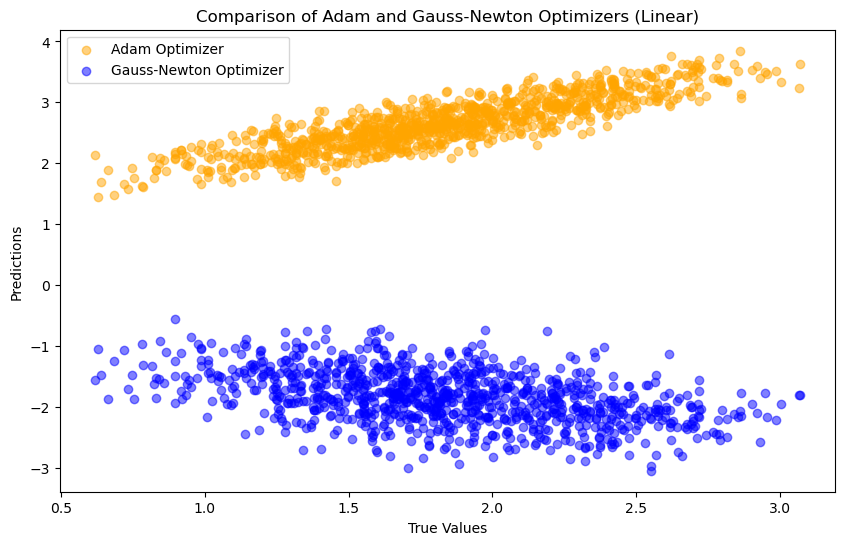

In [44]:
X, y = generate_linear_dataset()


# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Initialize BNN model
num_features = X_tensor.shape[1]
bnn_model = BNN(num_features=num_features)
bnn_model_gn = BNN(num_features=num_features)


# Train model using Adam optimizer
bnn_trained = adam_optimizer(bnn_model, X_tensor, y_tensor)
bnn_trained_gn = gauss_newton_optimizer(bnn_model_gn, X_tensor, y_tensor)



# Evaluate the models
mse, r2, predictions_adam = evaluate_model(bnn_trained, X_tensor, y)
mse_gn, r2_gn, predictions_gn = evaluate_model(bnn_trained_gn, X_tensor, y)

# Print metrics for both models
print("Adam Optimizer:")
print(f"Mean Squared Error: {mse}")
print("Gauss-Newton Optimizer:")
print(f"Mean Squared Error: {mse_gn}")

# Visualization
plt.figure(figsize=(10, 6))

# Plotting Adam optimizer predictions
plt.scatter(y, predictions_adam, alpha=0.5, label='Adam Optimizer', color='orange')

# Plotting Gauss-Newton optimizer predictions
plt.scatter(y, predictions_gn, alpha=0.5, label='Gauss-Newton Optimizer', color='blue')
title = "Comparison of Adam and Gauss-Newton Optimizers (Linear)"
plt.title(title)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend()
plt.savefig(title+'.png', bbox_inches='tight', dpi=150)
plt.show()


Adam Optimizer:
Mean Squared Error: 0.41180645749024436
Gauss-Newton Optimizer:
Mean Squared Error: 0.6607373959839795


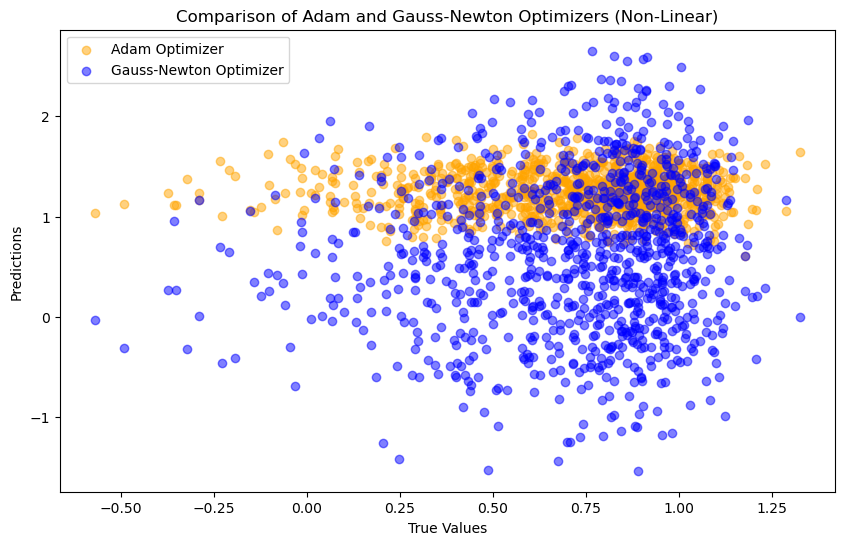

In [39]:
X, y = generate_non_linear_dataset()


# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Initialize BNN model
num_features = X_tensor.shape[1]
bnn_model = BNN(num_features=num_features)
bnn_model_gn = BNN(num_features=num_features)


# Train model using Adam optimizer
bnn_trained = adam_optimizer(bnn_model, X_tensor, y_tensor)
bnn_trained_gn = gauss_newton_optimizer(bnn_model_gn, X_tensor, y_tensor)



# Evaluate the models
mse, r2, predictions_adam = evaluate_model(bnn_trained, X_tensor, y)
mse_gn, r2_gn, predictions_gn = evaluate_model(bnn_trained_gn, X_tensor, y)

# Print metrics for both models
print("Adam Optimizer:")
print(f"Mean Squared Error: {mse}")
print("Gauss-Newton Optimizer:")
print(f"Mean Squared Error: {mse_gn}")

# Visualization
plt.figure(figsize=(10, 6))

# Plotting Adam optimizer predictions
plt.scatter(y, predictions_adam, alpha=0.5, label='Adam Optimizer', color='orange')

# Plotting Gauss-Newton optimizer predictions
plt.scatter(y, predictions_gn, alpha=0.5, label='Gauss-Newton Optimizer', color='blue')
title = "Comparison of Adam and Gauss-Newton Optimizers (Non-Linear)"
plt.title(title)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.legend()
plt.savefig(title+'.png', bbox_inches='tight', dpi=150)
plt.show()


Classification

In [57]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
df = pd.read_csv(url, names=names, na_values='?')

# Handle missing values
df = df.dropna()
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [58]:
# Convert the target to a binary classification problem
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Separate features and target variable
X = df.drop('target', axis=1)
y = df['target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)


In [59]:
class BNN(PyroModule):
    def __init__(self, num_features):
        super(BNN, self).__init__()
        self.fc1_weight = nn.Parameter(torch.randn(1, num_features))
        self.fc1_bias = PyroSample(Normal(0., 1.).expand([1]).to_event(1))

    def forward(self, x):
        f = torch.matmul(x, self.fc1_weight.T) + self.fc1_bias
        return torch.sigmoid(f)  


In [60]:
def evaluate_classification_model(model, x, y_true):
    with torch.no_grad():
        predictions = model(x)
        predicted_classes = (predictions > 0.5).float()
        accuracy = accuracy_score(y_true, predicted_classes)
    return accuracy


In [61]:
def adam_optimizer(model, x, y, learning_rate=0.01, num_epochs=1000):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

    return model

In [62]:
def gauss_newton_optimizer_classification(model, x, y, learning_rate=0.1, num_iterations=1000):
    criterion = nn.BCELoss()

    for iteration in range(num_iterations):
        # Forward pass
        output = model(x)

        # Calculate loss using BCE for binary classification
        loss = criterion(output, y)

        # Initialize approximate Hessian and gradient vector
        total_params = sum(p.numel() for p in model.parameters())
        approx_hessian = torch.zeros(total_params, total_params)
        loss_grads = torch.zeros(total_params)

        idx = 0
        for param in model.parameters():
            # Compute Jacobian for each parameter
            def model_output_with_params(p):
                original_param = param.data.clone()
                param.data = p.data
                output = model(x)
                param.data = original_param
                return output

            jacobian = torch.autograd.functional.jacobian(model_output_with_params, param)
            jacobian_flat = jacobian.view(jacobian.size(0), -1)

            # Update approximate Hessian
            outer_product = jacobian_flat.T @ jacobian_flat
            numel = param.numel()
            approx_hessian[idx:idx+numel, idx:idx+numel] = outer_product

            # Update loss gradients
            loss_grad = torch.autograd.grad(loss, param, retain_graph=True)[0].view(-1)
            loss_grads[idx:idx+numel] = loss_grad

            idx += numel

        # Solve for the parameter update (using a pseudo-inverse for stability)
        update_direction = torch.linalg.pinv(approx_hessian) @ loss_grads

        # Update parameters
        with torch.no_grad():
            idx = 0
            for param in model.parameters():
                numel = param.numel()
                param_update = update_direction[idx:idx + numel].view(param.shape)
                param -= learning_rate * param_update
                idx += numel

                # Check for NaN values
                if torch.isnan(param).any():
                    print("NaN values encountered. Adjust the learning rate.")
                    return model

    return model



Accuracy with Adam Optimizer: 0.8013468013468014
Accuracy with Gauss-Newton Optimizer: 0.6767676767676768


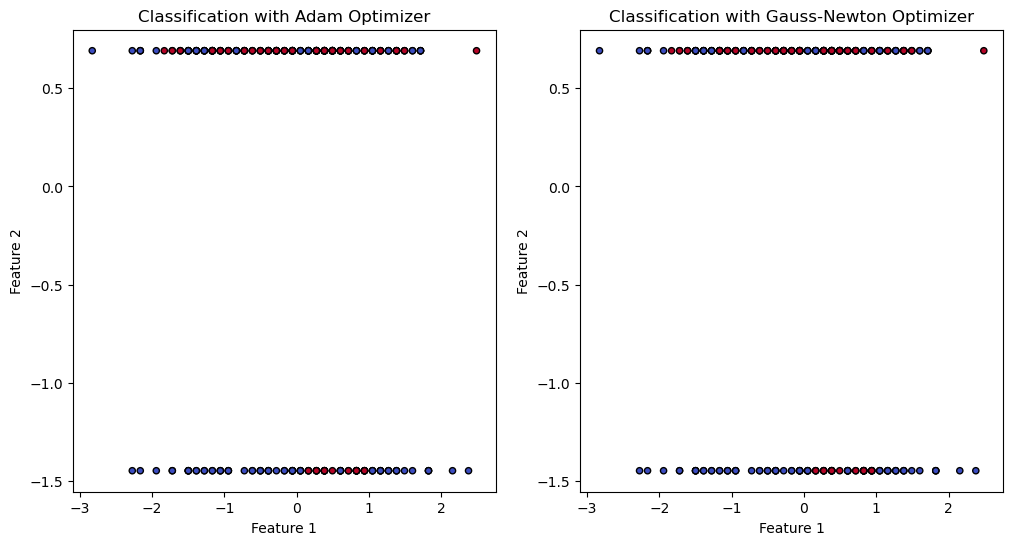

In [63]:
# Initialize BNN model
num_features = X_tensor.shape[1]
bnn_model_adam = BNN(num_features=num_features)
bnn_model_gn = BNN(num_features=num_features)

# Train model using Adam optimizer
bnn_trained_adam = adam_optimizer_classification(bnn_model_adam, X_tensor, y_tensor)
accuracy_adam = evaluate_classification_model(bnn_trained_adam, X_tensor, y_tensor)

# Train model using Gauss-Newton optimizer
bnn_trained_gn = gauss_newton_optimizer_classification(bnn_model_gn, X_tensor, y_tensor)
accuracy_gn = evaluate_classification_model(bnn_trained_gn, X_tensor, y_tensor)

# Print accuracies
print("Accuracy with Adam Optimizer:", accuracy_adam)
print("Accuracy with Gauss-Newton Optimizer:", accuracy_gn)

# Visualization code (assuming binary classification)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20)
plt.title('Classification with Adam Optimizer')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

plt.subplot(1, 2, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='coolwarm', edgecolor='k', s=20)
plt.title('Classification with Gauss-Newton Optimizer')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()
